In [20]:
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt


def compute_disparity_dp(lI, rI, sigma=2, c0=1):
    h, w = lI.shape
    left_disp_map = np.zeros_like(lI, dtype=np.float32)
    right_disp_map = np.zeros_like(rI, dtype=np.float32)

    for row in range(h):
        Il = lI[row].astype(np.float32)
        Ir = rI[row].astype(np.float32)
        N = len(Il)  # Width of the image row, this should be equal to 'w'
        D = np.zeros((N, N), dtype=np.float32)

        # Cost matrix initialization
        for i in range(N):
            for j in range(N):
                dij = ((Il[i] - Ir[j]) ** 2) / (sigma ** 2)
                if i == 0 and j == 0:
                    D[i, j] = dij
                elif i == 0:
                    D[i, j] = D[i, j-1] + c0
                elif j == 0:
                    D[i, j] = D[i-1, j] + c0
                else:
                    D[i, j] = min(
                        D[i-1, j-1] + dij,
                        D[i-1, j] + c0,
                        D[i, j-1] + c0
                    )

        # Backtracking to compute disparity maps
        i, j = N - 1, N - 1
        while i > 0 and j > 0:
            cost = D[i, j]
            dij = ((Il[i] - Ir[j]) ** 2) / (sigma ** 2)
            if cost == D[i-1, j-1] + dij:
                disp = abs(i - j)
                left_disp_map[row, i] = disp
                right_disp_map[row, j] = disp
                i -= 1
                j -= 1
            elif cost == D[i-1, j] + c0:
                i -= 1
            else:
                j -= 1

    return left_disp_map, right_disp_map, D

['l1.png', 'l2.png', 'l3.png', 'r1.png', 'r2.png', 'r3.png']


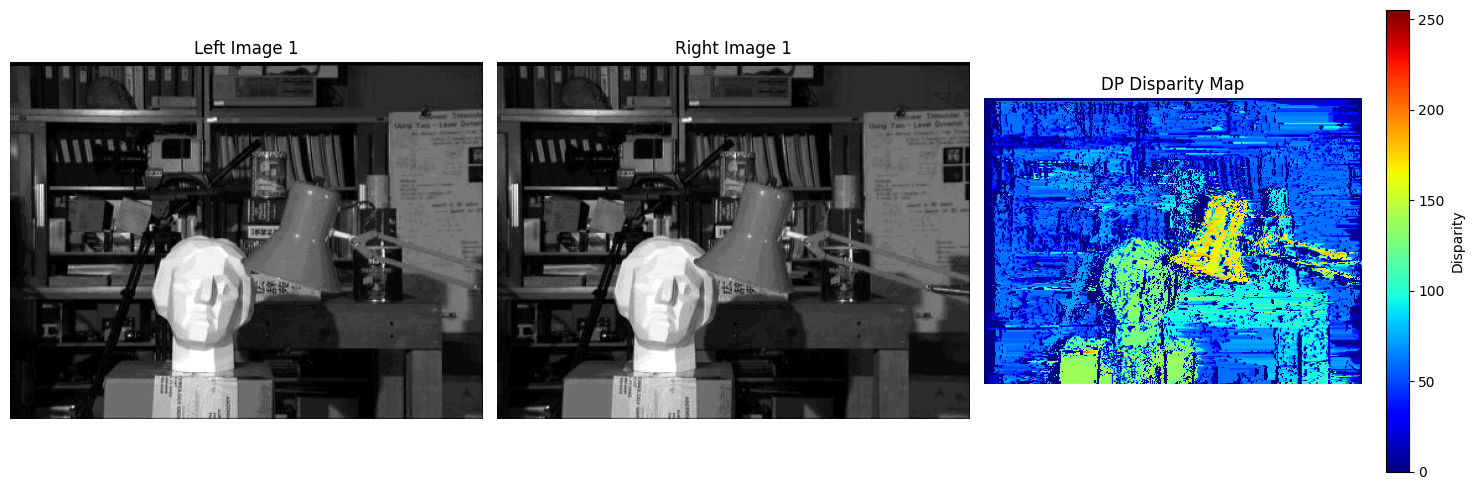

Disparity Cost Matrix (D) for image pair 1:
[[  1.     2.     3.   ... 380.   381.   382.  ]
 [  2.     3.     3.   ... 379.   380.   381.  ]
 [  3.     3.     3.25 ... 378.   379.   380.  ]
 ...
 [380.   379.   378.   ... 323.5  324.5  325.5 ]
 [381.   380.   379.   ... 324.5  325.5  326.5 ]
 [382.   381.   380.   ... 325.5  326.5  326.5 ]]


KeyboardInterrupt: 

In [22]:

def read_images_from_folder(folder_path):
    images = []
    filenames = sorted([f for f in os.listdir(folder_path) if f.endswith('.png')])
    print(filenames)
    
    for filename in filenames:
        image = cv2.imread(os.path.join(folder_path, filename))
        if image is not None:
            # Convert to grayscale
            image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
            images.append(image_gray)
    return images

def process_images(folder_path):
    images = read_images_from_folder(folder_path)
    
    if len(images) % 2 != 0:
        print("Please make sure the folder contains an even number of images (left-right pairs).")
        return

    # Split images into left and right image groups
    left_images = images[:len(images)//2]   # First half are left images
    right_images = images[len(images)//2:]  # Second half are right images
    
    for i in range(len(left_images)):
        lI = left_images[i]      # Left image
        rI = right_images[i]     # Right image
        
        # Resize both images to match each other if necessary
        if lI.shape != rI.shape:
            print("Resizing right image to match the left image's dimensions.")
            rI = cv2.resize(rI, (lI.shape[1], lI.shape[0]))  # Resize to match left image size
            
        # Resize both images to downscaled resolution (using a smaller factor)
        lI_resized = cv2.resize(lI, (0, 0), fx=1, fy=1)
        rI_resized = cv2.resize(rI, (0, 0), fx=1, fy=1)
        
        # Apply Gaussian smoothing (blurring) with a smaller kernel to preserve details
        lI_smoothed = cv2.GaussianBlur(lI_resized, (3, 3), 0)
        rI_smoothed = cv2.GaussianBlur(rI_resized, (3, 3), 0)

        # Compute disparity using dynamic programming on smoothed images
        dp_left_disp_map, dp_right_disp_map, D_matrix = compute_disparity_dp(lI_smoothed, rI_smoothed)
        normalized_disparity = cv2.normalize(dp_left_disp_map, None, 0, 255, cv2.NORM_MINMAX)

        # Create a figure with 3 subplots: left image, right image, and disparity map
        plt.figure(figsize=(15, 5))

        # Plot the left image
        plt.subplot(1, 3, 1)
        plt.imshow(lI_resized, cmap='gray')
        plt.title(f"Left Image {i+1}")
        plt.axis('off')

        # Plot the right image
        plt.subplot(1, 3, 2)
        plt.imshow(rI_resized, cmap='gray')
        plt.title(f"Right Image {i+1}")
        plt.axis('off')

        # Plot the disparity map
        plt.subplot(1, 3, 3)
        plt.imshow(normalized_disparity.astype(np.uint8), cmap='jet')
        plt.colorbar(label='Disparity')
        plt.title("DP Disparity Map")
        plt.axis('off')

        # Show the plot
        plt.tight_layout()
        plt.show()

        # Print the disparity cost matrix (D)
        print(f"Disparity Cost Matrix (D) for image pair {i+1}:")
        print(D_matrix)

# Example usage
folder_path = "images"  # Replace with the path to your image folder
process_images(folder_path)


